In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)

The `sklearn.datasets` provides:
1. `fetch_*` functions such as `fetch_openml()` to download real-life datasets
2. `load_*` functions to load small toy datasets bundled with Scikit-Learn
3. `make_*` functions to generate fake datasets, useful for tests
Generated datasets are usually returned as a tuple (X, y) containing the input data and the targets, both as NumPy arrays.\
Other datasets are returned as `sklearn.utils.Bunch` objects containing:
* `DESCR`: a description of the dataset
* `data`: the input data, usually as a 2D NumPy array
* `target`: the labels, usually as a 1D NumPy array 

In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X, y = mnist.data, mnist.target

In [6]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [8]:
X.shape, y.shape

((70000, 784), (70000,))

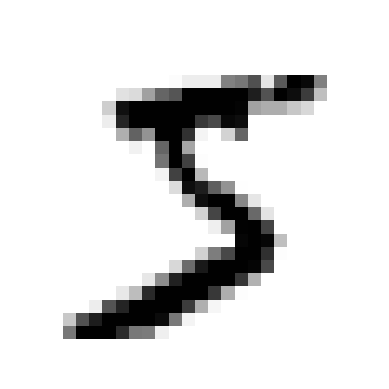

In [9]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [10]:
y[0]

'5'

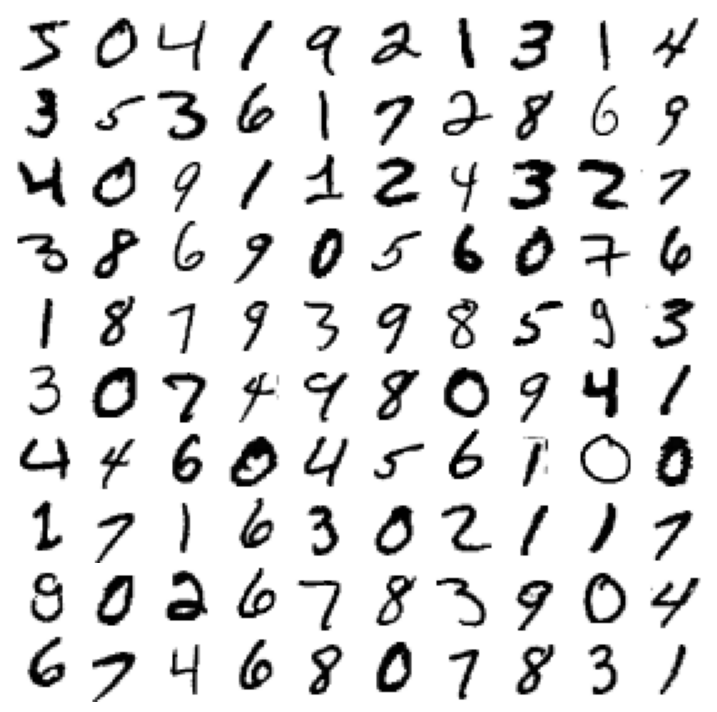

In [11]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx+1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

## Training a Binary Classifier

In [ ]:
X_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Stochastic Gradient Descent (SGD) is classifier that is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning

In [14]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy using Cross-Validation

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

False


In [18]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

**Implementing Cross-Validation**

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


### Confusion Matrices

`cross_val_predict` performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

Each row represents an **actual class**, while each column represents a **predicted class**.

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

The first row considers non-5 images (**negative class**): 53,892 of them were correctly classified (**true negatives**), while the remaining 687 were wrongly classified (**false positives**).\
The second row considers the images of 5s (**positive class**): 1891 were wrongly classified (**false negative**), while the remaining 3530 were correctly classified (**true positive**)

In [23]:
# Perfect classifier
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

**Precision**: The accuracy of the positive predictions
$$precision = \frac{TP}{TP+FP}$$

**Recall**: aka *sensitivity* or *true positive rate (TPR)*. The ratio of positive instances that are correctly detected by the classifier
$$recall=\frac{TP}{TP+FN}$$

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

np.float64(0.8370879772350012)

In [25]:
recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

When it claims an image represents a 5, it is correcct only 83.7% of the time. Moreover, it only detects 65.1% of the real 5s

**F1 score**: the harmonic mean of precision and recall
$$F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\times\frac{precision\times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

`decision_function()` method returns a score for each instance, then you can use any threshold you want to make predictions based on those scores

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [31]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447], shape=(60000,))

`precision_recall_curve()` computes precision and recall for all possible thresholds

In [32]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [33]:
thresholds

array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
         38871.26391927,   42216.05562787,   49441.43765905],
      shape=(60000,))

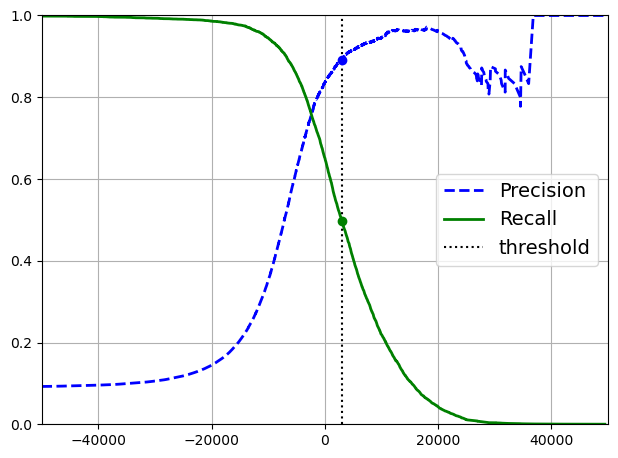

In [34]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax() # first index >= threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

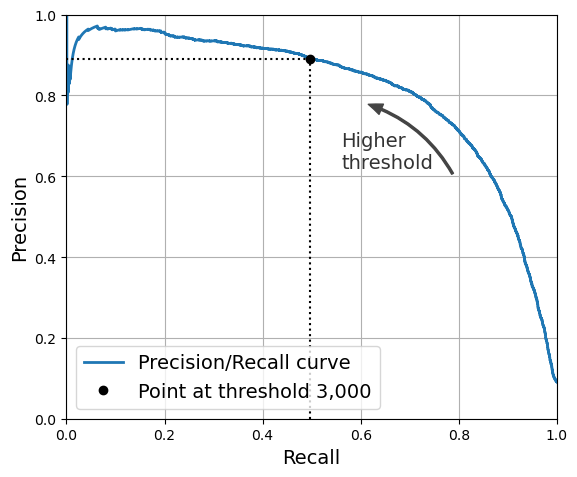

In [35]:
import matplotlib.patches as patches  # for the curved arrow

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [36]:
# get the lowest threshold that gives you at least 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]

In [37]:
threshold_for_90_precision

np.float64(3370.0194991439557)

In [38]:
# Make predictions
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [39]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [40]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

np.float64(0.4799852425751706)

### The ROC Curve
The Receiver Operating Characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead plotting precision versus recall, the ROC curve plots the true positive rate (TPR) against false positive rate (FPR).

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

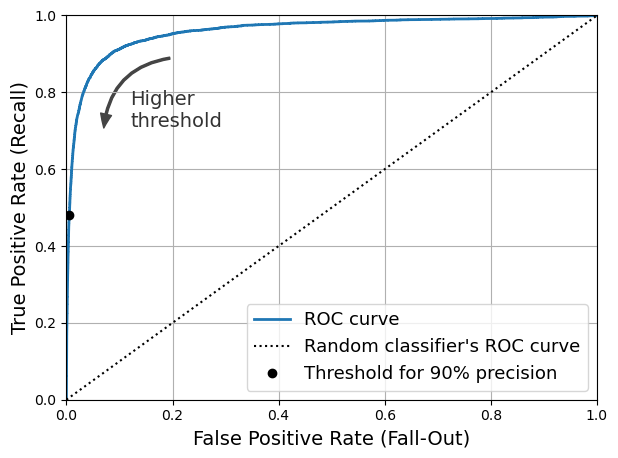

In [42]:
idx_for_threshold_at_90 = (threshold <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

The higher the recall (TPR), the more false positives (FPR) the classifier produces.\
One way to compare classifiers is to measure the *area under the curve (AUC)*. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [44]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [45]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [46]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [47]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

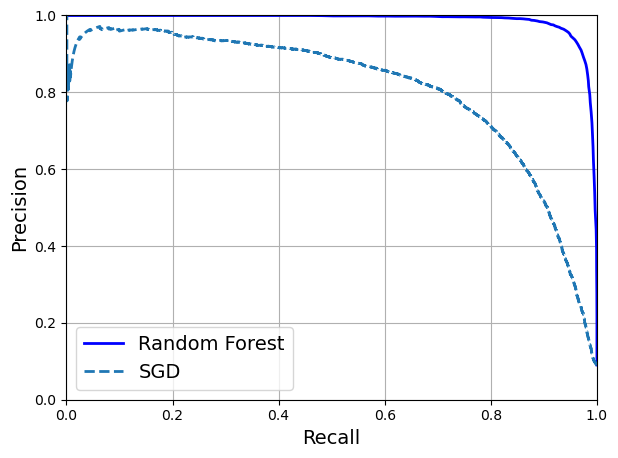

In [48]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

In [49]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba >= 50%
f1_score(y_train_5, y_train_pred_forest)

np.float64(0.9274509803921569)

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [51]:
precision_score(y_train_5, y_train_pred_forest)

np.float64(0.9897468089558485)

In [52]:
recall_score(y_train_5, y_train_pred_forest)

np.float64(0.8725327430363402)

## Multiclass Classification / Multinomal Classifier

Some classifiers, such as `LogisticRegression`, `RandomForestClassifier`, `GaussianNB`, are capable of handling multiple classes natively. Others are strictly binary classifiers, such as `SGDClassifier`, and `SVC`. However, there are various strategies that can be used to perform multiclass classification with multiple binary classifiers.
1. **one-versus-the-rest (OvR) or one-versus-all (OvA)**\
   By training 10 binary classifiers (0-9), then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score
2. **one-versus-one (OvO)**\
   By training a binary classifier for every pair of digits: one to distinguish 0s and 1s; another to distinguish 0s and 2s, and so on. If there are N classes, then there'll be $\frac{N\times(N-1)}{2}$ classifiers. For this case, there'll be 45 binary classifiers

In [53]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [54]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [56]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [57]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [58]:
svm_clf.classes_[class_id]

'5'

In [59]:
# Using OvR strategy
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [60]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [61]:
len(ovr_clf.estimators_)

10

Training an `SGDClassifier` on a multiclass dataset and using it to make predictions

In [62]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [63]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [65]:
# Scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", verbose=2)

[CV] END .................................................... total time= 5.8min
[CV] END .................................................... total time= 5.5min
[CV] END .................................................... total time= 5.6min


array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, verbose=2)

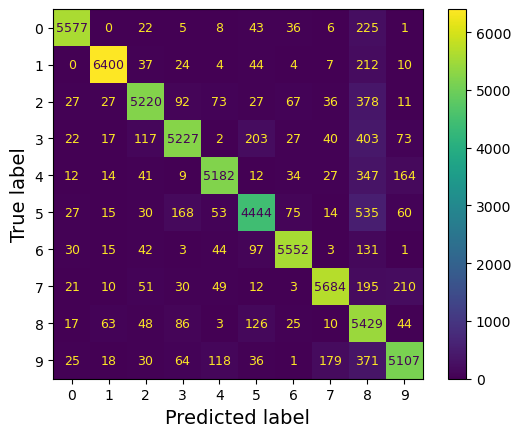

In [70]:
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

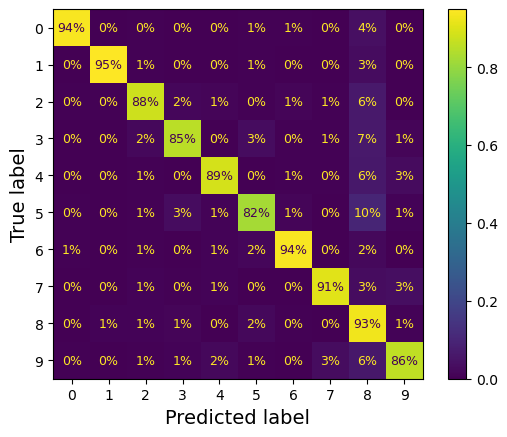

In [72]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

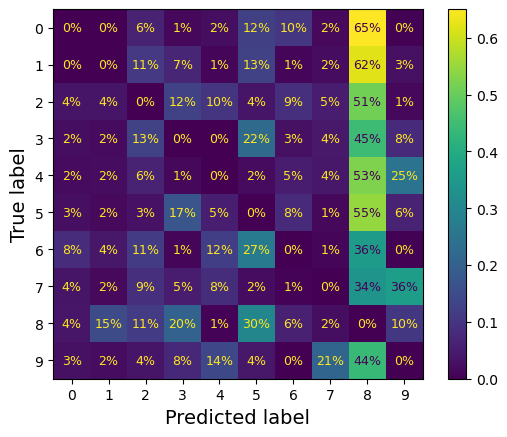

In [71]:
# Putting zero weight on the correct predictions to make the errors stand out more
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true",
                                        values_format=".0%")
plt.show()

36% on row#7 col#9 means that 36% of the errors the model made on images of 7s were misclassified as 9s

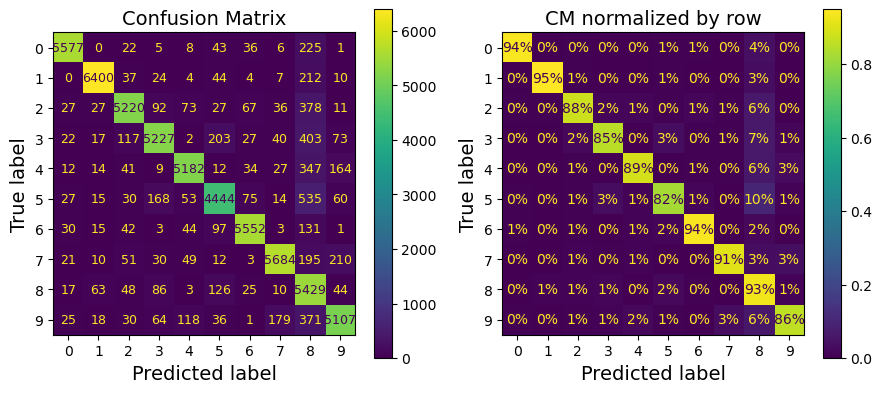

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion Matrix")
plt.rc("font", size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1], normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

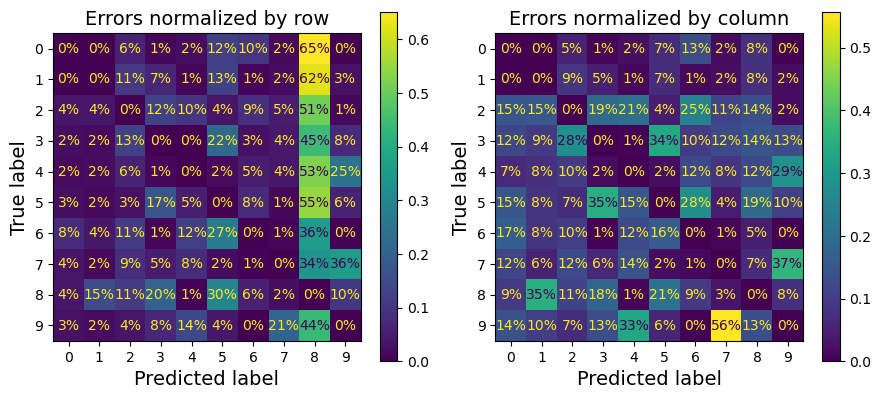

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc("font", size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight, normalize="true",
                                        values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight, normalize="pred",
                                        values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc("font", size=14) # reset the fontsize

By analyzing the confusion matrix, we can get insight into ways to improve our classifier. For example, it seems that our efforts should be spent on reducing the false 8s. 
1. We could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s.
2. We could engineer new features that would help the classifier, for example, writing an algorithm to count the number of closed loops (8 has two, 6 has 1, 5 has none)
3. We could preprocess the images (using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more

In [80]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

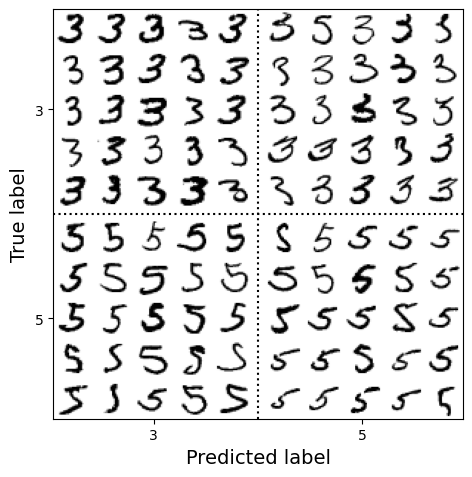

In [81]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

## Multilabel Classification
a classification system that outputs multiple binary tags

In [89]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [90]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]], shape=(60000, 2))

In [91]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [92]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

np.float64(0.9764102655606048)

## Multioutput Classification
a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).\
For example, when we build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities. This output itself is multilabel (one label per pixel) with each label can have multiple values (ranges from 0 to 255).

In [99]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
X_test_mod = x_test + noise
y_train_mod = X_train
y_test_mod = x_test

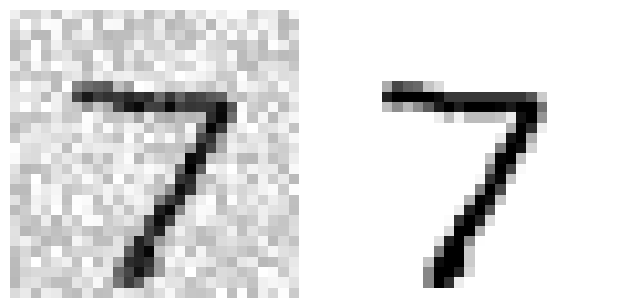

In [100]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

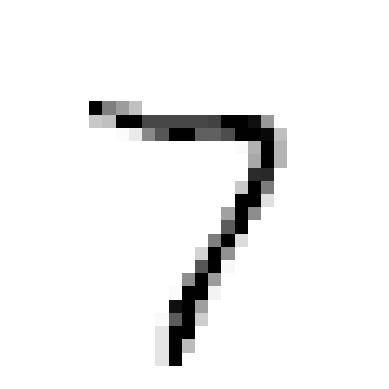

In [101]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

# Exercises

## 1. an MNIST Classifier with over 97% Accuracy
Build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

In [104]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(x_test, y_test)
baseline_accuracy

0.9688

In [111]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    "weights": ["uniform", "distance"],
    "n_neighbors": [3, 4, 5, 6, 7]
}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid=param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6, 7],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [112]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [113]:
grid_search.best_score_

np.float64(0.9703500000000002)

In [114]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(x_test, y_test)
tuned_accuracy

0.9714

## 2. Data Augmentation / Training Set Expansion
Write a function that can shift an MNIST image in any direction (left, right, up, down) by one pixel. Then for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set.

In [134]:
from scipy.ndimage import shift
# Function to shift an MNIST image
def shift_image(image, direction):
    if direction == "left":
        return shift(image.reshape(28, 28), [0, -1], cval=0).reshape(784)
    elif direction == "right":
        return shift(image.reshape(28, 28), [0, 1], cval=0).reshape(784)
    elif direction == "up":
        return shift(image.reshape(28, 28), [-1, 0], cval=0).reshape(784)
    elif direction == "down":
        return shift(image.reshape(28, 28), [1, 0], cval=0).reshape(784)

directions = ["left", "right", "up", "down"]
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for direction in directions:
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, direction))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [135]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_augmented, y_train_augmented, test_size=10_000)

In [137]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_) # ** is used to unpack a dictionary
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [138]:
knn_clf.score(X_test, y_test)

0.9871

## 3. Tackle the Titanic dataset
Download the dataset: https://www.kaggle.com/c/titanic \
Goal: Train a classifier that can predict the `Survived` column based on the other columns

## 4. Build a Spam Classifier
1. Download the dataset: https://spamassassin.apache.org/old/publiccorpus/ 
2. Unzip the datasets and familiarize yourself with the data format
3. Split the data into a training set and a test set
4. Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible words. For example, if all emails only ever contain four words, "Hello", "how", "are", "you", then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning ["hello" is present, "how" is absent, "are" is present, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word \
   \
   You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL”, replace all numbers with “NUMBER”, or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this)
5. Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision